In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from tqdm import tqdm_notebook, tnrange
from itertools import chain
#from skimage.io import imread, imshow, concatenate_images
#from skimage.transform import resize
#from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model, model_from_json
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [20]:
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd 
import imutils
import cv2
import timeit
import cProfile
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#cutstrainpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\train\\cuts\\'
#maskstrainpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\train\\masks\\'
#cutsvalidpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\valid\\cuts\\'
#masksvalidpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\valid\\masks\\'

cutstestpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\test\\cuts\\'
maskstestpath = 'C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\test\\masks\\'


im_width = 80
im_height = 80
imgsize = 80

In [4]:
def load_cuts(pathname):
    X_train = []
    
    for f in os.listdir(pathname):
        if f.endswith('.png'):
            img = np.zeros([imgsize,imgsize,3],dtype=np.uint8)
            img = cv2.imread(os.path.join(pathname, f),1)
            
            assert img.shape == (imgsize, imgsize, 3)

            X_train.append(img)
        
    return X_train

def load_masks(pathname):
    y_train = []
    imgblue = [[[0 for x in range(imgsize)] for y in range(imgsize)]  for z in range(3)]
  
    for f in os.listdir(pathname):
        if f.endswith('.png'):
            #print(os.path.join(pathname, f))
            #img_blue = [[[0 for x in range(imgsize)] for y in range(imgsize)]  for z in range(3)]
            img_blue = np.zeros([imgsize,imgsize,3],dtype=np.uint8)
            
            img = cv2.imread(os.path.join(pathname, f),1)
            
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
            assert img_gray.shape == (imgsize, imgsize)

            img_blue[:,:,2] = img_gray
            
            y_train.append(img_blue)
     
    return y_train

In [5]:
def showcuts(datalist, lastpics=10):

    assert lastpics <= len(datalist)

    orgtail = datalist[len(datalist)-lastpics:]

    columns = 5
    rows = lastpics//columns
    fig=plt.figure(figsize=(15, 2*rows))
    for i in range(columns*rows):
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(orgtail[i])

In [6]:
json_file = open('C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\modeltrained.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:\\Users\\rembo\\Documents\\classes\\DCPS\\Trash\\modeltrained.h5")
print("Loaded model from disk")

Loaded model from disk


In [7]:
loaded_model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])
loaded_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 80, 80, 3)    0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 80, 80, 16)   448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 80, 80, 16)   64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 80, 80, 16)   0           batch_normalization_73[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 10, 10, 256)  0           conv2d_transpose_17[0][0]        
                                                                 activation_80[0][0]              
__________________________________________________________________________________________________
dropout_37 (Dropout)            (None, 10, 10, 256)  0           concatenate_17[0][0]             
__________________________________________________________________________________________________
conv2d_87 (Conv2D)              (None, 10, 10, 128)  295040      dropout_37[0][0]                 
__________________________________________________________________________________________________
batch_normalization_83 (BatchNo (None, 10, 10, 128)  512         conv2d_87[0][0]                  
__________________________________________________________________________________________________
activation

In [8]:
X_test = load_cuts(cutstestpath)
print(len(X_test))
y_test = load_masks(maskstestpath)
print(len(y_test))

318
318


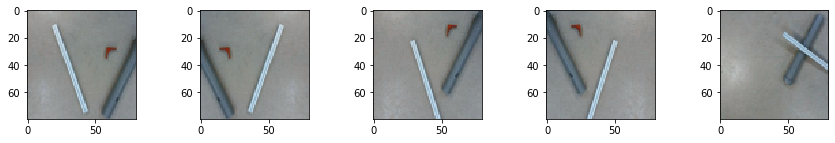

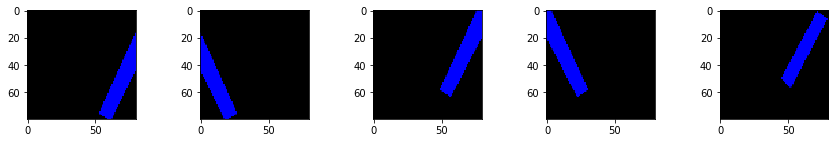

In [9]:
X_pics=X_test.copy()
y_pics=y_test.copy()


showcuts(X_pics, 6)
showcuts(y_pics, 6)

In [10]:
X_test = np.array(X_test, dtype=np.float32)


X_test -= X_test.mean()
X_test /= X_test.std()

In [11]:
predictions_test = loaded_model.predict(X_test, batch_size=32, verbose=1)

318/318 [==============================] - ETA: 13 - ETA: 8 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 23ms/step


In [15]:
def predictedmask(piclist, thresh=0.6):
    y_list = []
    for pic in piclist:
        assert pic.shape == (imgsize, imgsize, 3)
            
        imgret = np.zeros((imgsize, imgsize,3), np.uint8)
        for i in range(imgsize):
            for j in range(imgsize):
                if pic[i,j,2] >= thresh:
                    imgret[i,j,2] = 255
                else:
                    imgret[i,j,2] = 0
        y_list.append(imgret)
    return y_list

In [22]:
0.006*318

1.9080000000000001

         640 function calls in 9.983 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    9.977    9.977    9.983    9.983 <ipython-input-15-eb4fa06fbf94>:1(predictedmask)
        1    0.000    0.000    9.983    9.983 <string>:1(<module>)
        1    0.000    0.000    9.983    9.983 {built-in method builtins.exec}
      318    0.005    0.000    0.005    0.000 {built-in method numpy.zeros}
      318    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




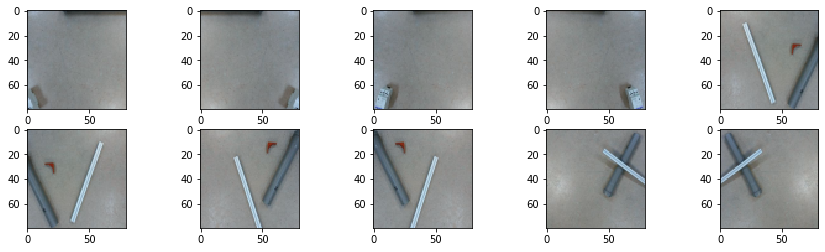

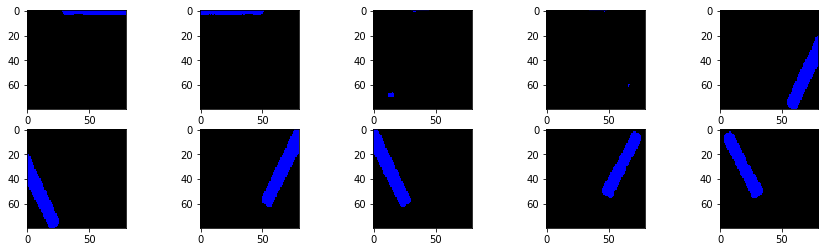

In [23]:
predictions_pics=[]
#predictions_pics = predictedmask(predictions_test,0.5)
cProfile.run('predictions_pics = predictedmask(predictions_test,0.5)')
showcuts(X_pics, 10)
showcuts(predictions_pics, 10)

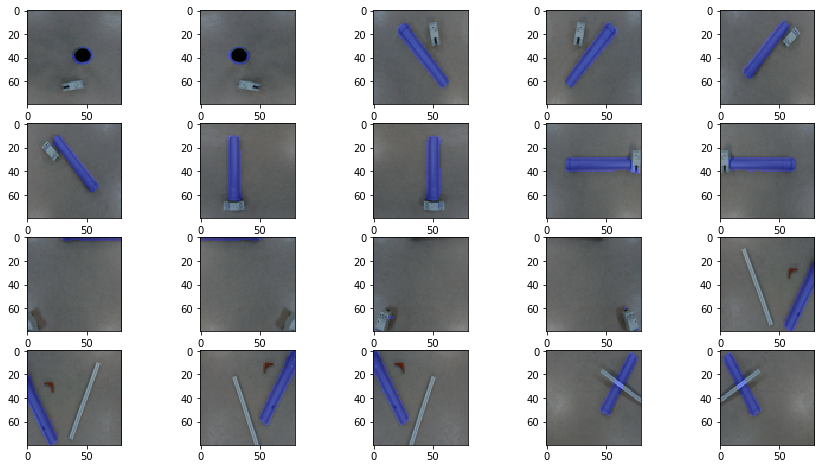

In [14]:
imglist=[]
for c,m in zip(X_pics, predictions_pics):
    imglist.append(cv2.addWeighted(c, 0.7, m, 0.3, 0))
    
showcuts(imglist, 20)